# PROBLEM 4 Yanis Tazi

# My contribution :

# I created the homogen code for the group and ask folks to run different resnet on different GPUs. On my side, I run resnet20 (and50 for q2) on :
    
# -Jupyter HUB (T4 Gpu) (not used)

# -GCP us-west1b : K80 and P100 GPUs
    
# -GCP asia east1c : V100 GPU . This one was really hard to get as there was no quota in almost all regions for the V100 but I was successful on asia east 1c.

# Teammates for data aggregation :

# Erik, Annamalai, Apoorva, Kshitji

# Code that I created to homogeneize with my group the results for  resnet history losses in GCP using 3 GPUs

# #############################################################################################################################################################################################

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import tensorflow.keras as keras
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10  
from numpy import save
from numpy import savetxt
from numpy import loadtxt
from time import time
import pandas as pd



from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import numpy as np
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from numpy import savetxt
from numpy import loadtxt
from tensorflow.keras.callbacks import Callback

Please install GPU version of TF


# Some functions 

In [3]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


class Histories(Callback):

    def on_train_begin(self,logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Data Preparation

In [3]:

subtract_pixel_mean = True
num_classes = 10

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# ResNet 20

In [4]:
batch_size = 128 
epochs =350
data_augmentation = False



n = 3 
depth = n * 6 + 2

model_type = 'ResNet20'

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

Learning rate:  0.001


In [5]:



# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)



# run training, with or without data augmentation.



In [ ]:
histories = Histories()

callbacks = [checkpoint, lr_reducer, lr_scheduler,histories]

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x_train,y_train,
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),  ### Testing is done with original images.
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)



In [7]:
savetxt('resnet20_history_losses.csv', histories.losses, delimiter=',')

# ResNet 32

In [8]:
batch_size = 128 
epochs =350
data_augmentation = False



n = 5 
depth = n * 6 + 2

model_type = 'ResNet32'

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

Learning rate:  0.001


In [9]:



# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)



# run training, with or without data augmentation.



In [ ]:
histories = Histories()

callbacks = [checkpoint, lr_reducer, lr_scheduler,histories]

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x_train,y_train,
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),  ### Testing is done with original images.
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)



In [ ]:
savetxt('resnet32_history_losses.csv', histories.losses, delimiter=',')

# ResNet 44

In [ ]:
batch_size = 128 
epochs =350
data_augmentation = False



n = 7 
depth = n * 6 + 2

model_type = 'ResNet44'

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

In [ ]:



# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)



# run training, with or without data augmentation.



In [ ]:
histories = Histories()

callbacks = [checkpoint, lr_reducer, lr_scheduler,histories]

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x_train,y_train,
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),  ### Testing is done with original images.
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)



In [ ]:
savetxt('resnet44_history_losses.csv', histories.losses, delimiter=',')

# ResNet 56

In [ ]:
batch_size = 128 
epochs =350
data_augmentation = False



n = 9
depth = n * 6 + 2

model_type = 'ResNet56'

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

In [ ]:



# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)



# run training, with or without data augmentation.



In [ ]:
histories = Histories()

callbacks = [checkpoint, lr_reducer, lr_scheduler,histories]

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x_train,y_train,
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),  ### Testing is done with original images.
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)



In [ ]:
savetxt('resnet56_history_losses.csv', histories.losses, delimiter=',')

# #############################################################################################################################################################################################

# Q1)

In [16]:
import numpy as np
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (20,10)


def fit_func(x, beta_0, beta_1, beta_2):
    return ((1/(beta_0*x+beta_1)) + beta_2)


# Please note that the person in charge for resnet18 k80 in our group could not provide us with the results. The prof said that it was fine if the other 14 models were available.

# ResNet 18 :

# (b) V100

In [17]:
results_rn18_v100 = loadtxt("resnet18_history_losses_v100.csv",delimiter=',')

x = np.array(range(1,len(results_rn18_v100)+1))
y = results_rn18_v100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn18_v100, beta_1_rn18_v100, beta_2_rn18_v100] = params[0]
print ("beta0 = ",beta_0_rn18_v100, "beta1 = ", beta_1_rn18_v100, "beta2 = ", beta_2_rn18_v100)

beta0 =  0.000296555220181137 beta1 =  0.5299375968629125 beta2 =  0.07674270195876437


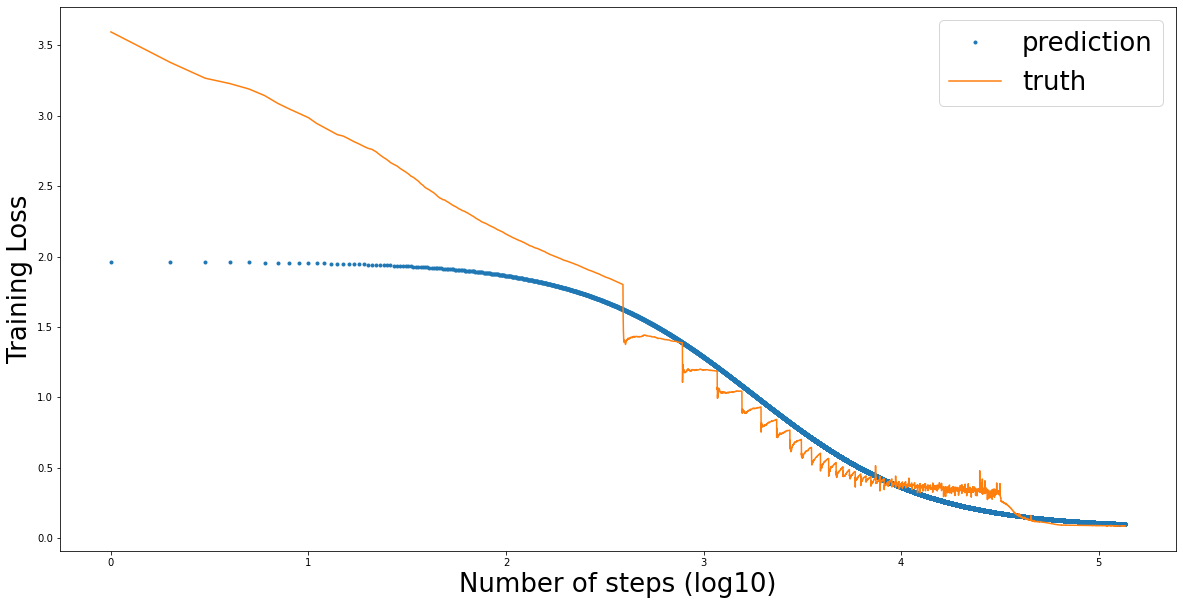

In [18]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn18_v100, beta_1_rn18_v100, beta_2_rn18_v100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) P100

In [19]:
results_rn18_p100 = loadtxt("resnet18_history_losses_p100.csv",delimiter=',')



x = np.array(range(1,len(results_rn18_p100)+1))
y = results_rn18_p100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn18_p100, beta_1_rn18_p100, beta_2_rn18_p100] = params[0]
print ("beta0 = ",beta_0_rn18_p100, "beta1 = ", beta_1_rn18_p100, "beta2 = ", beta_2_rn18_p100)

beta0 =  0.00029977668470001936 beta1 =  0.5224734039282408 beta2 =  0.08043512302593799


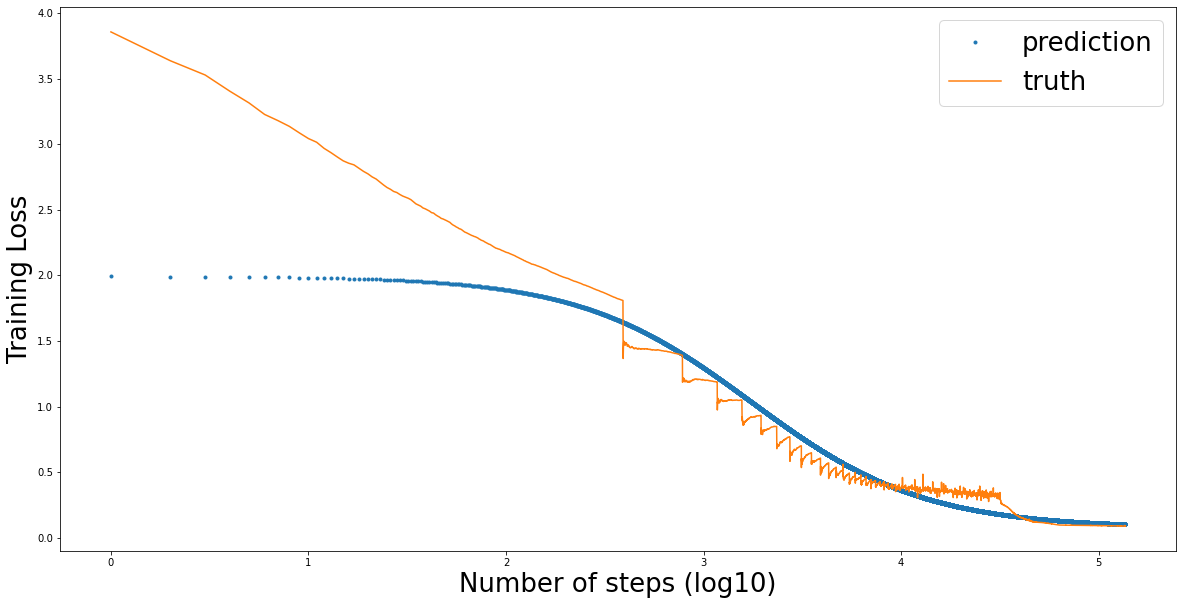

In [20]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn18_p100, beta_1_rn18_p100, beta_2_rn18_p100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# ResNet 20 :

# (a) k80

In [21]:
results_rn20_k80 = loadtxt("resnet20_history_losses_k80.csv",delimiter=',')



x = np.array(range(1,len(results_rn20_k80)+1))
y = results_rn20_k80


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn20_k80, beta_1_rn20_k80, beta_2_rn20_k80] = params[0]
print ("beta0 = ",beta_0_rn20_k80, "beta1 = ", beta_1_rn20_k80, "beta2 = ", beta_2_rn20_k80)

beta0 =  0.0004266341162200351 beta1 =  0.5322582788429069 beta2 =  0.050120152645948886


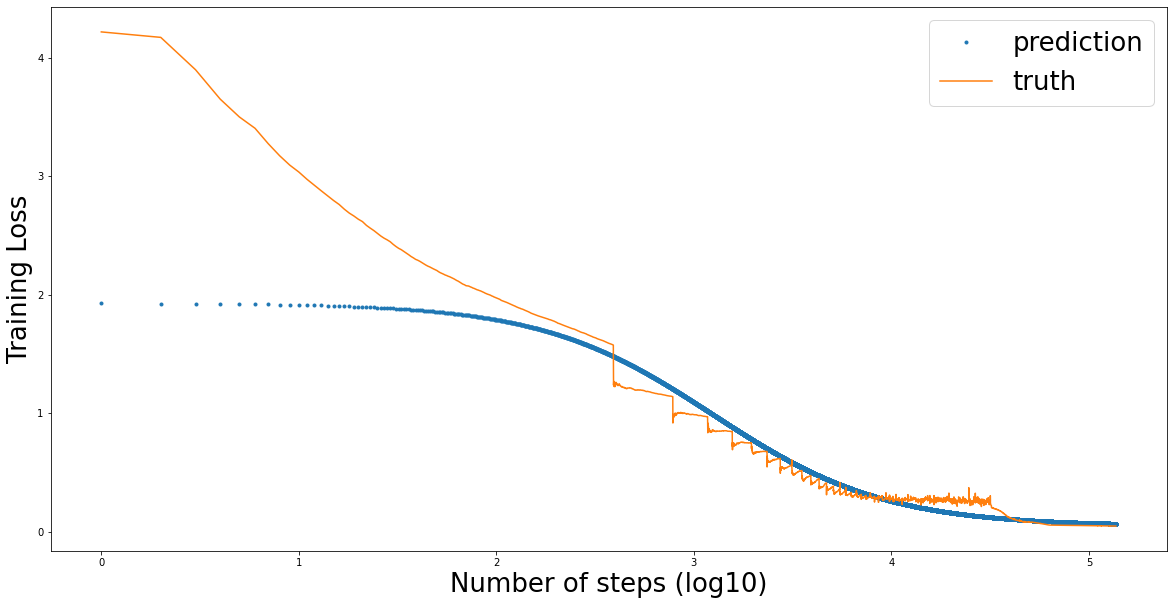

In [22]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn20_k80, beta_1_rn20_k80, beta_2_rn20_k80),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (b) V100

In [23]:
results_rn20_v100 = loadtxt("resnet20_history_losses_v100.csv",delimiter=',')

x = np.array(range(1,len(results_rn20_v100)+1))
y = results_rn20_v100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn20_v100, beta_1_rn20_v100, beta_2_rn20_v100] = params[0]
print ("beta0 = ",beta_0_rn20_v100, "beta1 = ", beta_1_rn20_v100, "beta2 = ", beta_2_rn20_v100)

beta0 =  0.0004016637153526492 beta1 =  0.5477098468113405 beta2 =  0.051005836687181574


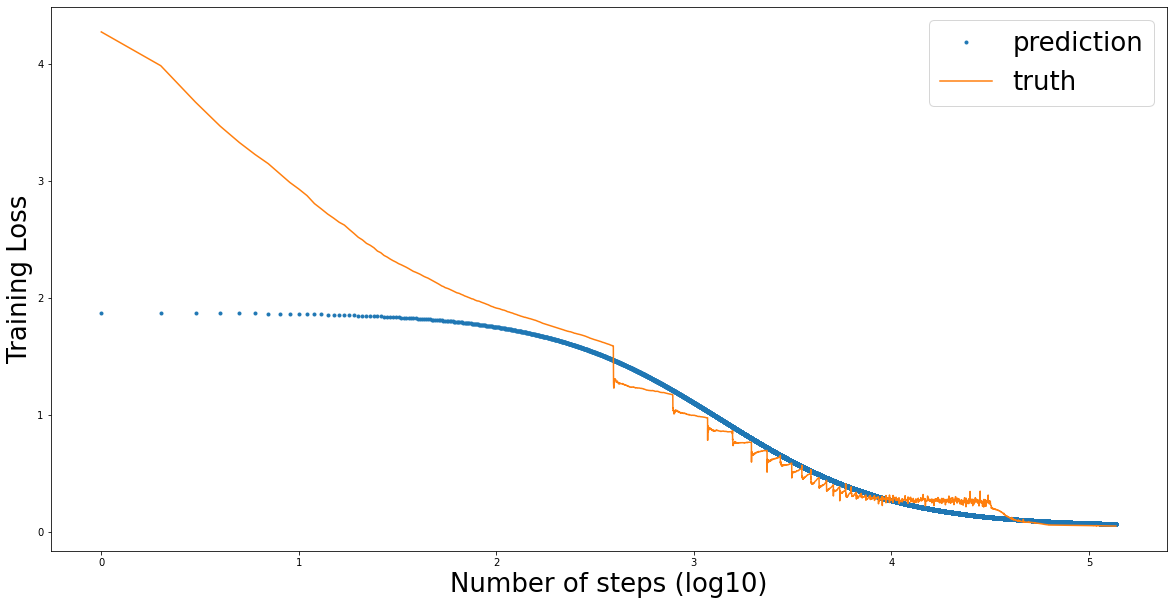

In [24]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn20_v100, beta_1_rn20_v100, beta_2_rn20_v100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) P100

In [25]:
results_rn20_p100 = loadtxt("resnet20_history_losses_p100.csv",delimiter=',')



x = np.array(range(1,len(results_rn20_p100)+1))
y = results_rn20_p100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn20_p100, beta_1_rn20_p100, beta_2_rn20_p100] = params[0]
print ("beta0 = ",beta_0_rn20_p100, "beta1 = ", beta_1_rn20_p100, "beta2 = ", beta_2_rn20_p100)

beta0 =  0.00042825469866446806 beta1 =  0.5220698503664709 beta2 =  0.05299538379064824


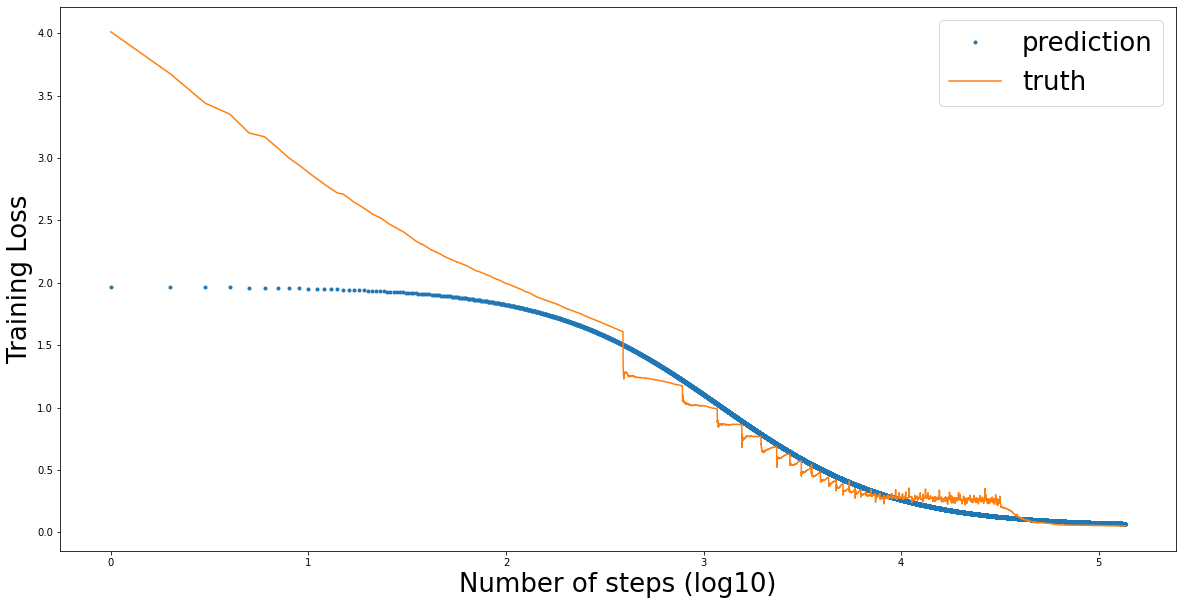

In [26]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn20_p100, beta_1_rn20_p100, beta_2_rn20_p100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# ResNet 32 :

# (a) k80

In [27]:
results_rn32_k80 = loadtxt("resnet32_history_losses_k80.csv",delimiter=',')



x = np.array(range(1,len(results_rn32_k80)+1))
y = results_rn32_k80


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn32_k80, beta_1_rn32_k80, beta_2_rn32_k80] = params[0]
print ("beta0 = ",beta_0_rn32_k80, "beta1 = ", beta_1_rn32_k80, "beta2 = ", beta_2_rn32_k80)

beta0 =  0.00037618344396607277 beta1 =  0.49382920904864913 beta2 =  0.05153904325774589


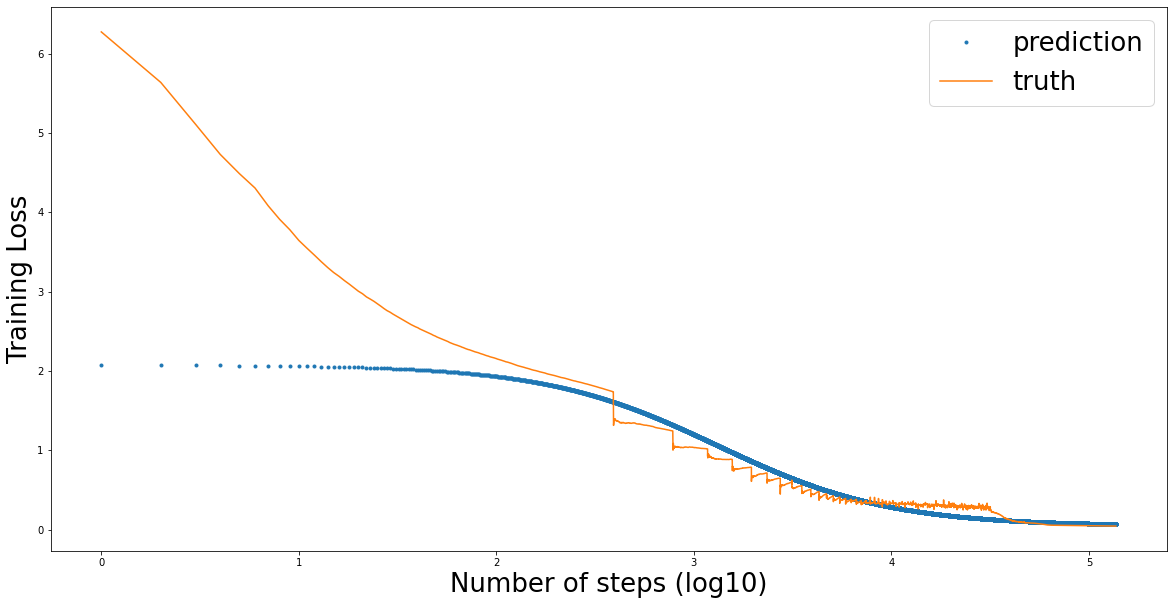

In [28]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn32_k80, beta_1_rn32_k80, beta_2_rn32_k80),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (b) V100

In [29]:
results_rn32_v100 = loadtxt("resnet32_history_losses_v100.csv",delimiter=',')



x = np.array(range(1,len(results_rn32_v100)+1))
y = results_rn32_v100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn32_v100, beta_1_rn32_v100, beta_2_rn32_v100] = params[0]
print ("beta0 = ",beta_0_rn32_v100, "beta1 = ", beta_1_rn32_v100, "beta2 = ", beta_2_rn32_v100)

beta0 =  0.0003599624959140204 beta1 =  0.5317098403563155 beta2 =  0.054248425259714794


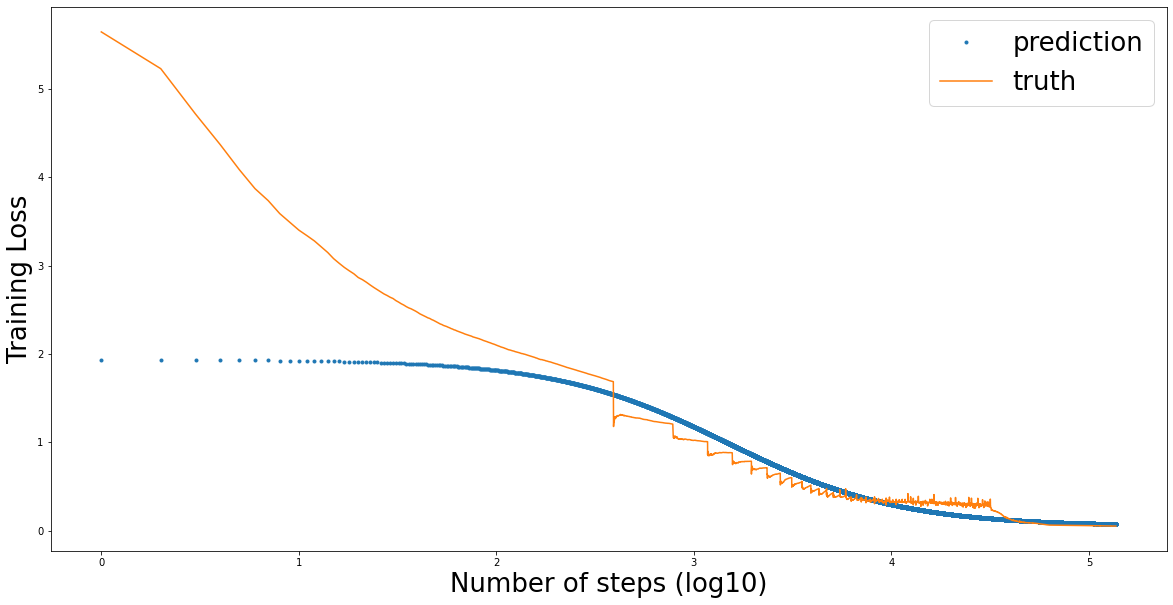

In [30]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn32_v100, beta_1_rn32_v100, beta_2_rn32_v100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) P100

In [31]:
results_rn32_p100 = loadtxt("resnet32_history_losses_p100.csv",delimiter=',')



x = np.array(range(1,len(results_rn32_p100)+1))
y = results_rn32_p100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn32_p100, beta_1_rn32_p100, beta_2_rn32_p100] = params[0]
print ("beta0 = ",beta_0_rn32_p100, "beta1 = ", beta_1_rn32_p100, "beta2 = ", beta_2_rn32_p100)

beta0 =  0.00033400935735280205 beta1 =  0.5683688130458241 beta2 =  0.04853459204095913


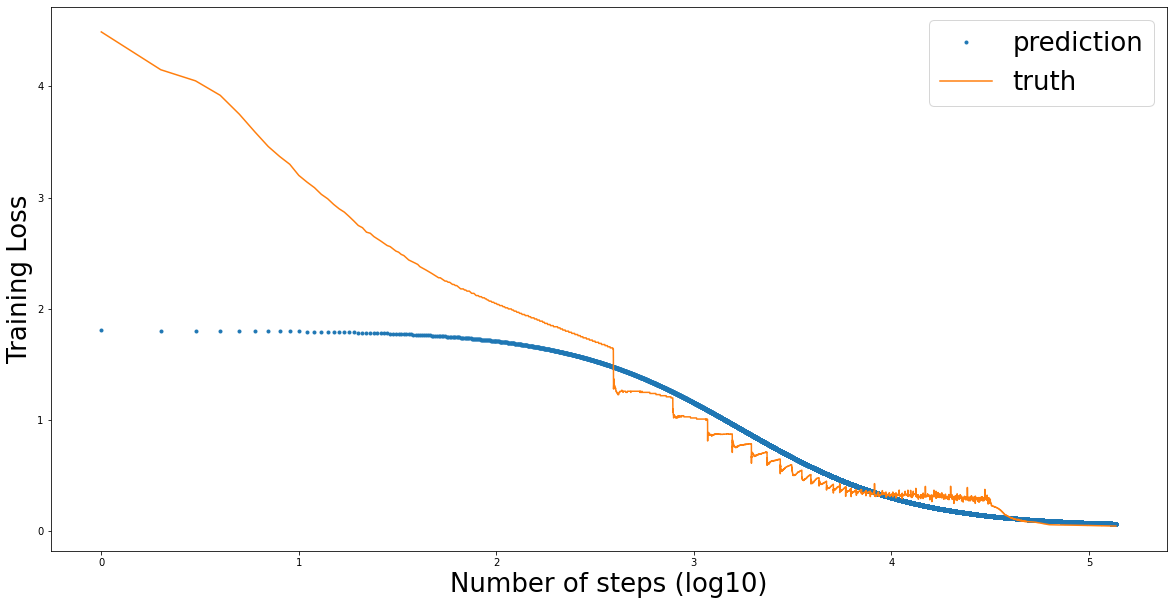

In [32]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn32_p100, beta_1_rn32_p100, beta_2_rn32_p100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# ResNet 44 :

# (a) k80

In [33]:
results_rn44_k80 = loadtxt("resnet44_history_losses_k80.csv",delimiter=',')



x = np.array(range(1,len(results_rn44_k80)+1))
y = results_rn44_k80


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn44_k80, beta_1_rn44_k80, beta_2_rn44_k80] = params[0]
print ("beta0 = ",beta_0_rn44_k80, "beta1 = ", beta_1_rn44_k80, "beta2 = ", beta_2_rn44_k80)

beta0 =  0.0002838895954286186 beta1 =  0.4965314721642189 beta2 =  0.04220455271156387


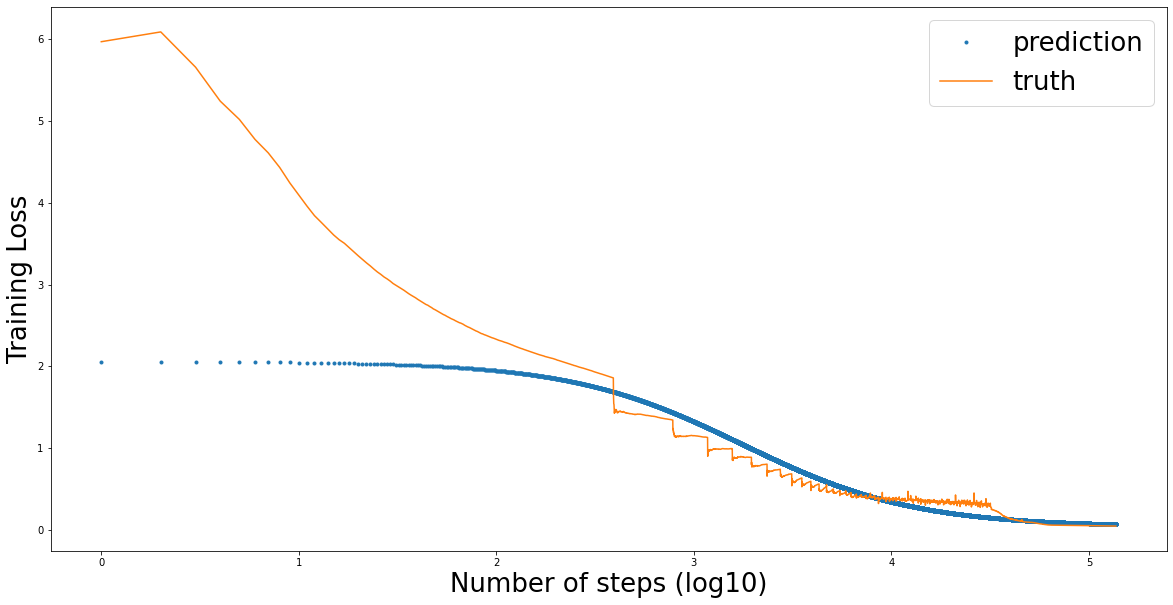

In [34]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn44_k80, beta_1_rn44_k80, beta_2_rn44_k80),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (b) V100

In [35]:
results_rn44_v100 = loadtxt("resnet44_history_losses_v100.csv",delimiter=',')

x = np.array(range(1,len(results_rn44_v100)+1))
y = results_rn44_v100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn44_v100, beta_1_rn44_v100, beta_2_rn44_v100] = params[0]
print ("beta0 = ",beta_0_rn44_v100, "beta1 = ", beta_1_rn44_v100, "beta2 = ", beta_2_rn44_v100)

beta0 =  0.00024530340503913493 beta1 =  0.5684564301467389 beta2 =  0.03327848379581292


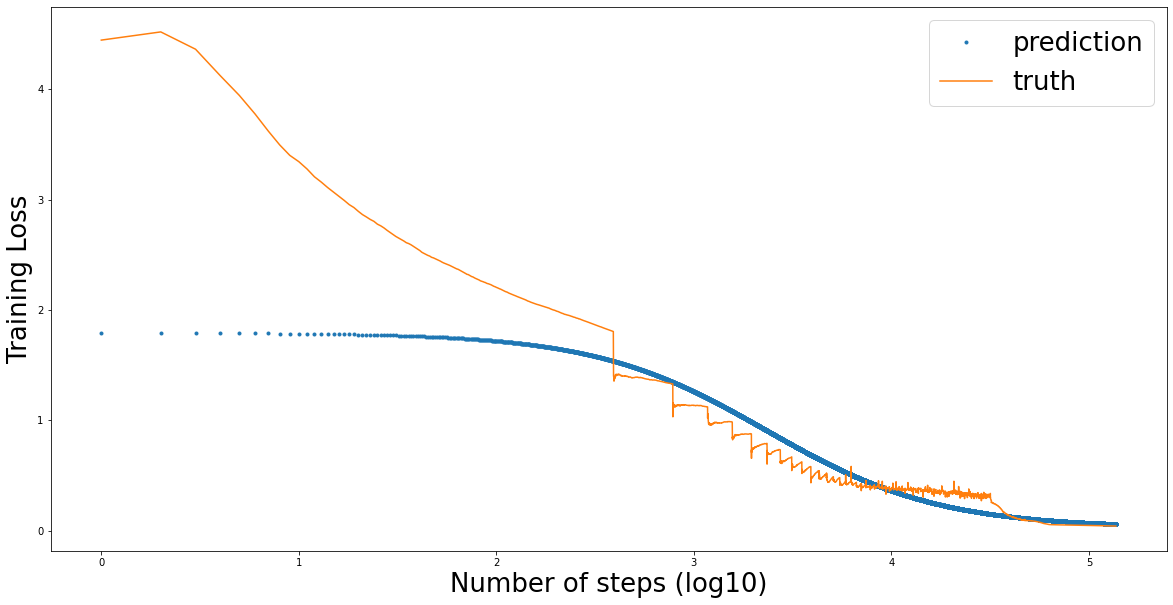

In [36]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn44_v100, beta_1_rn44_v100, beta_2_rn44_v100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) P100

In [37]:
results_rn44_p100 = loadtxt("resnet44_history_losses_p100.csv",delimiter=',')



x = np.array(range(1,len(results_rn44_p100)+1))
y = results_rn44_p100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn44_p100, beta_1_rn44_p100, beta_2_rn44_p100] = params[0]
print ("beta0 = ",beta_0_rn44_p100, "beta1 = ", beta_1_rn44_p100, "beta2 = ", beta_2_rn44_p100)

beta0 =  0.000454540572897251 beta1 =  0.34713713441909577 beta2 =  0.07092443067230292


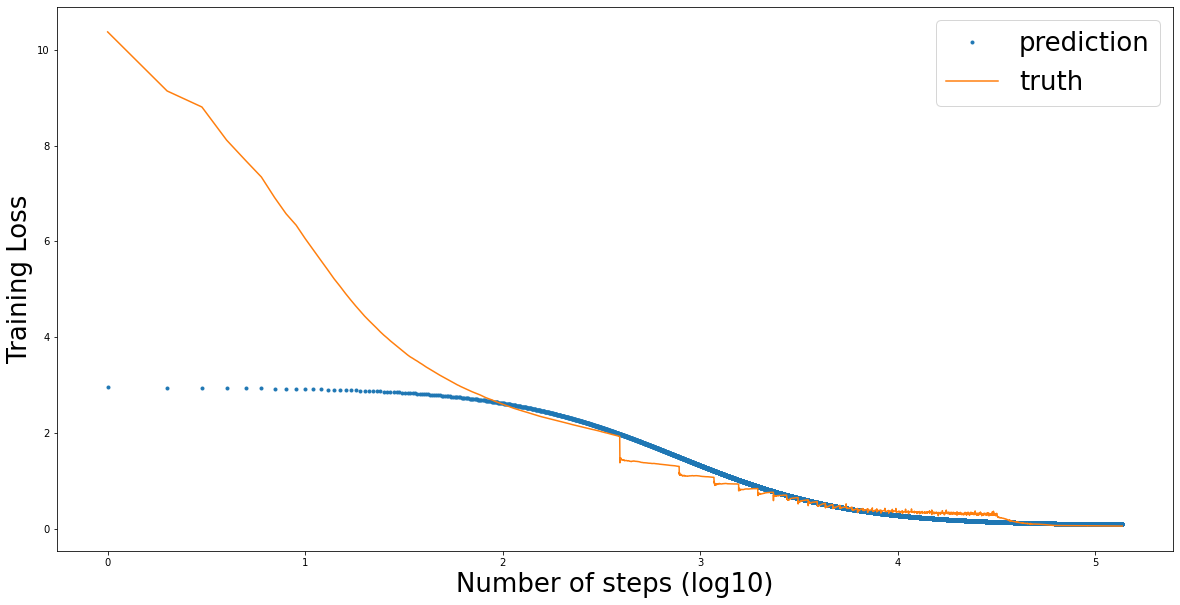

In [38]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn44_p100, beta_1_rn44_p100, beta_2_rn44_p100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# ResNet 56 :

# (a) k80

In [39]:
results_rn56_k80 = loadtxt("resnet56_history_losses_k80.csv",delimiter=',')



x = np.array(range(1,len(results_rn56_k80)+1))
y = results_rn56_k80


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn56_k80, beta_1_rn56_k80, beta_2_rn56_k80] = params[0]
print ("beta0 = ",beta_0_rn56_k80, "beta1 = ", beta_1_rn56_k80, "beta2 = ", beta_2_rn56_k80)

beta0 =  0.0003004067637836595 beta1 =  0.4119063243317991 beta2 =  0.049572398591079266


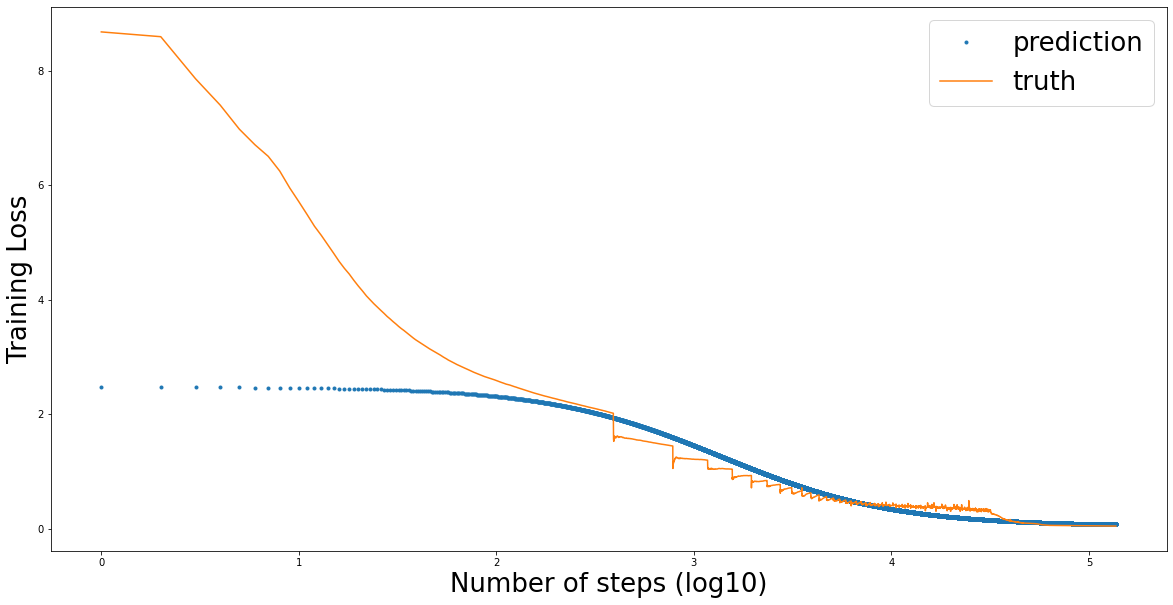

In [40]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn56_k80, beta_1_rn56_k80, beta_2_rn56_k80),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (b) V100

In [41]:
results_rn56_v100 = loadtxt("resnet56_history_losses_v100.csv",delimiter=',')

x = np.array(range(1,len(results_rn56_v100)+1))
y = results_rn56_v100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn56_v100, beta_1_rn56_v100, beta_2_rn56_v100] = params[0]
print ("beta0 = ",beta_0_rn56_v100, "beta1 = ", beta_1_rn56_v100, "beta2 = ", beta_2_rn56_v100)

beta0 =  0.00023581169502799463 beta1 =  0.5104931375731508 beta2 =  0.02446110241401359


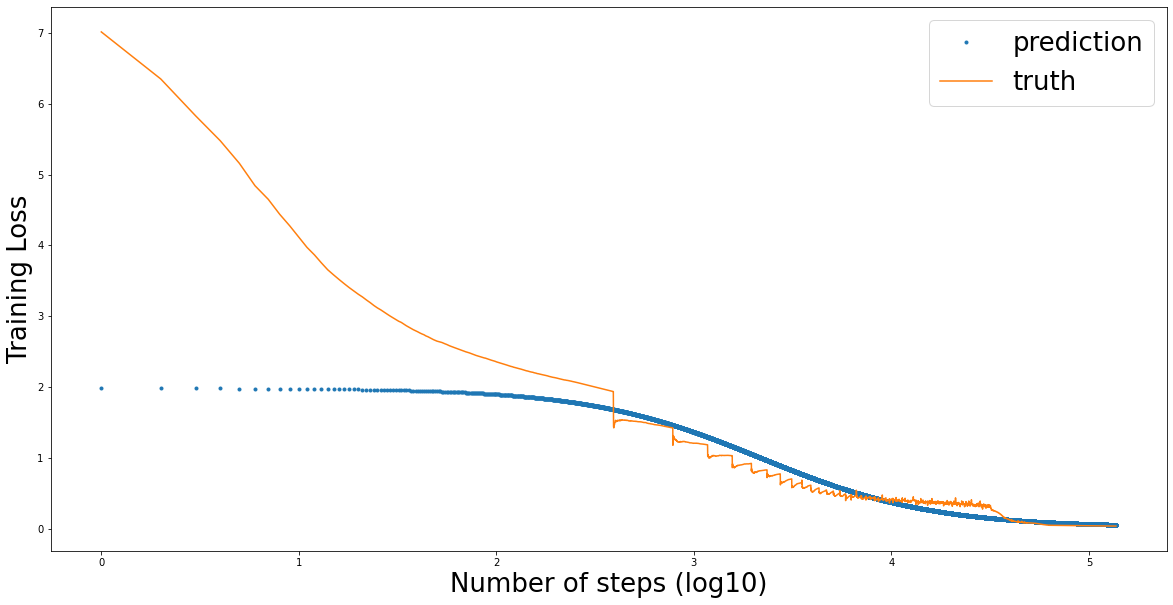

In [42]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn56_v100, beta_1_rn56_v100, beta_2_rn56_v100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) P100

In [43]:
results_rn56_p100 = loadtxt("resnet56_history_losses_p100.csv",delimiter=',')



x = np.array(range(1,len(results_rn56_p100)+1))
y = results_rn56_p100


params = curve_fit(fit_func, x, y, p0=[0.01,0,1])

[beta_0_rn56_p100, beta_1_rn56_p100, beta_2_rn56_p100] = params[0]
print ("beta0 = ",beta_0_rn56_p100, "beta1 = ", beta_1_rn56_p100, "beta2 = ", beta_2_rn56_p100)

beta0 =  0.0003703801958244291 beta1 =  0.3502656111760361 beta2 =  0.06092635955214064


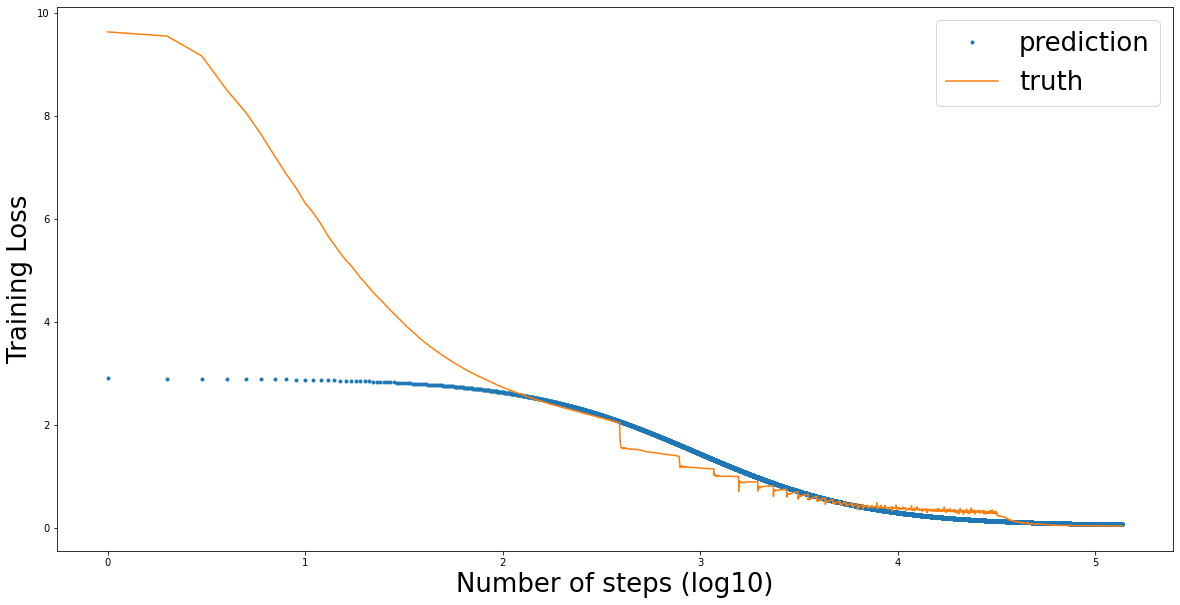

In [44]:
plt.plot(np.log10(x),fit_func(x,beta_0_rn56_p100, beta_1_rn56_p100, beta_2_rn56_p100),marker=".",linestyle="None",label="prediction")
plt.plot(np.log10(x),y,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

In [45]:
# Save all the betas for q2 :

BETA_0 = [beta_0_rn18_p100,beta_0_rn18_v100,
         beta_0_rn20_k80,beta_0_rn20_p100,beta_0_rn20_v100,
         beta_0_rn32_k80,beta_0_rn32_p100,beta_0_rn32_v100,
         beta_0_rn44_k80,beta_0_rn44_p100,beta_0_rn44_v100,
         beta_0_rn56_k80,beta_0_rn56_p100,beta_0_rn56_v100]

BETA_1 = [beta_1_rn18_p100,beta_1_rn18_v100,
         beta_1_rn20_k80,beta_1_rn20_p100,beta_1_rn20_v100,
         beta_1_rn32_k80,beta_1_rn32_p100,beta_1_rn32_v100,
         beta_1_rn44_k80,beta_1_rn44_p100,beta_1_rn44_v100,
         beta_1_rn56_k80,beta_1_rn56_p100,beta_1_rn56_v100]

BETA_2 = [beta_2_rn18_p100,beta_2_rn18_v100,
         beta_2_rn20_k80,beta_2_rn20_p100,beta_2_rn20_v100,
         beta_2_rn32_k80,beta_2_rn32_p100,beta_2_rn32_v100,
         beta_2_rn44_k80,beta_2_rn44_p100,beta_2_rn44_v100,
         beta_2_rn56_k80,beta_2_rn56_p100,beta_2_rn56_v100]

savetxt("BETA0_q1.csv",BETA_0,delimiter=",")
savetxt("BETA1_q1.csv",BETA_1,delimiter=",")
savetxt("BETA2_q1.csv",BETA_2,delimiter=",")

# Q2)

# The results for Resnet 50 are in the following notebook : HW4_training_rn50_k80_p100_v100.ipynb .
# I ran the three models on three different GPUs on GCP .

beta_0 = A_1 * num_layers + A_2 * GPU_k80 + A_3 * GPU_p100 + A_4 * GPU_v100

beta_1 = B_1 * num_layers + B_2 * GPU_k80 + B_3 * GPU_p100 + B_4 * GPU_v100

beta_2 = C_1 * num_layers + C_2 * GPU_k80 + C_3 * GPU_p100 + C_4 * GPU_v100

so we will have 3 regression models with 15 points and we will  learn coeff (A_1,...,C_4)

From those we can predict 3 loss l = 1/(beta_0_pred + k beta_1_pred) +beta_2_pred for each GPU.

 To get the number of epochs to achieve 92% accuracy , we  need to map the training loss value corresponding to  92% validation accuracy  and compare this to prediction corresponding to this training loss

# Step 1 : Get estimate coefficients values for predicted beta_0,beta_1 and beta_2 from the 14 models .

In [46]:
from sklearn.linear_model import LinearRegression

BETA_0 = loadtxt("BETA0_q1.csv")
BETA_1 = loadtxt("BETA1_q1.csv")
BETA_2 = loadtxt("BETA2_q1.csv")

# 3 regression models for the betas :

y = BETA_0
X = np.array([[18,0,1,0],[18,0,0,1],[20,1,0,0],[20,0,1,0],[20,0,0,1],[32,1,0,0],[32,0,1,0],[32,0,0,1],[44,1,0,0],[44,0,1,0],[44,0,0,1],[56,1,0,0],[56,0,1,0],[56,0,0,1]])
reg_BETA_0 = LinearRegression().fit(X, y)


y = BETA_1
X = np.array([[18,0,1,0],[18,0,0,1],[20,1,0,0],[20,0,1,0],[20,0,0,1],[32,1,0,0],[32,0,1,0],[32,0,0,1],[44,1,0,0],[44,0,1,0],[44,0,0,1],[56,1,0,0],[56,0,1,0],[56,0,0,1]])
reg_BETA_1 = LinearRegression().fit(X, y)


y = BETA_2
X = np.array([[18,0,1,0],[18,0,0,1],[20,1,0,0],[20,0,1,0],[20,0,0,1],[32,1,0,0],[32,0,1,0],[32,0,0,1],[44,1,0,0],[44,0,1,0],[44,0,0,1],[56,1,0,0],[56,0,1,0],[56,0,0,1]])
reg_BETA_2 = LinearRegression().fit(X, y)

# Step 2 : Predict betas coefficients for Resnet 50 using the coefficients values to predict beta_0,beta_1 and beta_2 :

In [47]:
beta_0_k80_resnet50_pred = reg_BETA_0.predict(np.array([[50,1,0,0]]))
beta_1_k80_resnet50_pred = reg_BETA_1.predict(np.array([[50,1,0,0]]))
beta_2_k80_resnet50_pred = reg_BETA_2.predict(np.array([[50,1,0,0]]))


beta_0_p100_resnet50_pred = reg_BETA_0.predict(np.array([[50,0,1,0]]))
beta_1_p100_resnet50_pred = reg_BETA_1.predict(np.array([[50,0,1,0]]))
beta_2_p100_resnet50_pred = reg_BETA_2.predict(np.array([[50,0,1,0]]))


beta_0_v100_resnet50_pred = reg_BETA_0.predict(np.array([[50,0,0,1]]))
beta_1_v100_resnet50_pred = reg_BETA_1.predict(np.array([[50,0,0,1]]))
beta_2_v100_resnet50_pred = reg_BETA_2.predict(np.array([[50,0,0,1]]))

# Step 3 : Use the predicted beta_0,beta_1 and beta_2 coefficients predicted to predict the loss :

# Instead of target accuracy of 92 % I train the 3 models (GPU k80,v100 and P100) on 350 epochs . Prof said we can do so if the model doesn't reach 92% accuracy . It is because in my group we used Adam optimizer.

# (a) Predicted Resnet50 k80 loss and prediction error

In [48]:
predict_resnet50_k80_loss = []
results_rn50_k80 = loadtxt("resnet50_history_losses_k80.csv",delimiter=',')

for x in range(len(results_rn50_k80)):
    predict_resnet50_k80_loss.append((1/(beta_0_k80_resnet50_pred*x+beta_1_k80_resnet50_pred)) + beta_2_k80_resnet50_pred)


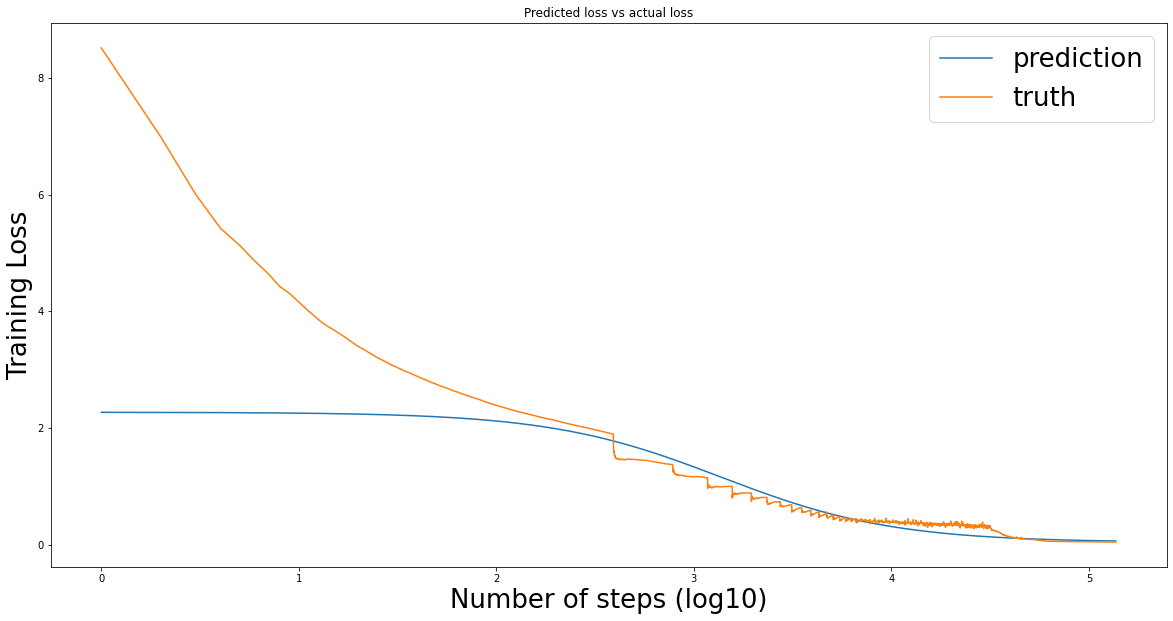

In [52]:


plt.plot(np.log10(range(1,len(results_rn50_k80)+1)),predict_resnet50_k80_loss,label="prediction")
plt.plot(np.log10(range(1,len(results_rn50_k80)+1)),results_rn50_k80,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.title("Predicted loss vs actual loss")
plt.show()





# (b) Predicted Resnet50 P100 loss

In [55]:
predict_resnet50_p100_loss = []
results_rn50_p100 = loadtxt("resnet50_history_losses_p100.csv",delimiter=',')
for x in range(len(results_rn50_p100)):
    predict_resnet50_p100_loss.append((1/(beta_0_p100_resnet50_pred*x+beta_1_p100_resnet50_pred)) + beta_2_p100_resnet50_pred)


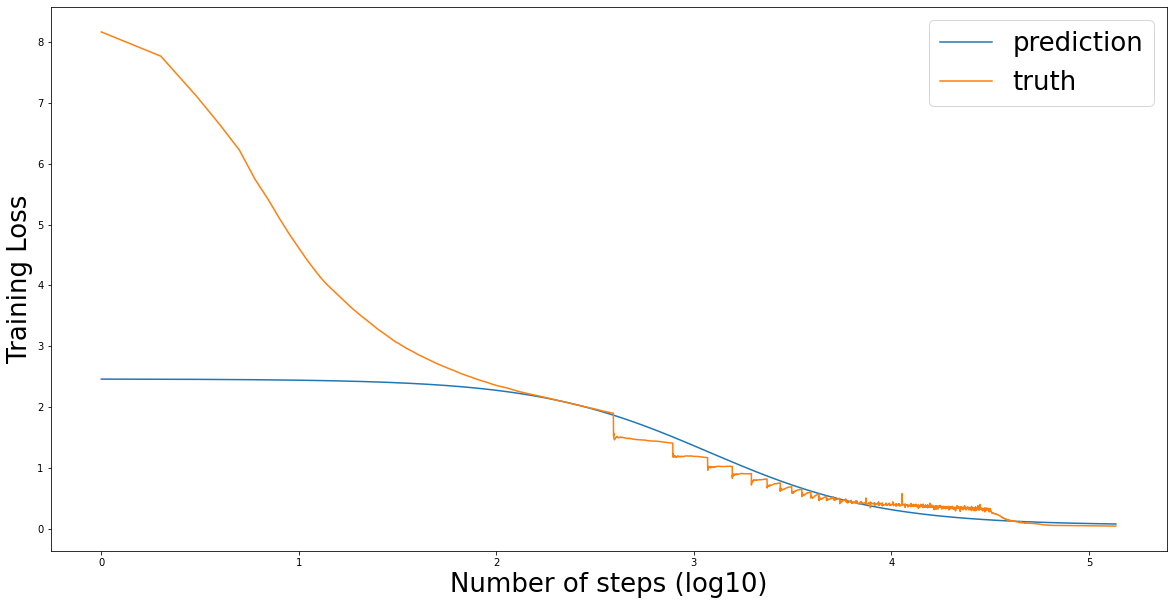

In [56]:
plt.plot(np.log10(range(1,len(results_rn50_p100)+1)),predict_resnet50_p100_loss,label="prediction")
plt.plot(np.log10(range(1,len(results_rn50_p100)+1)),results_rn50_p100,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

# (c) Predicted Resnet50 V100 loss

In [57]:
predict_resnet50_v100_loss = []
results_rn50_v100 = loadtxt("resnet50_history_losses_v100.csv",delimiter=',')


for x in range(len(results_rn50_v100)):
    predict_resnet50_v100_loss.append((1/(beta_0_v100_resnet50_pred*x+beta_1_v100_resnet50_pred)) + beta_2_v100_resnet50_pred)


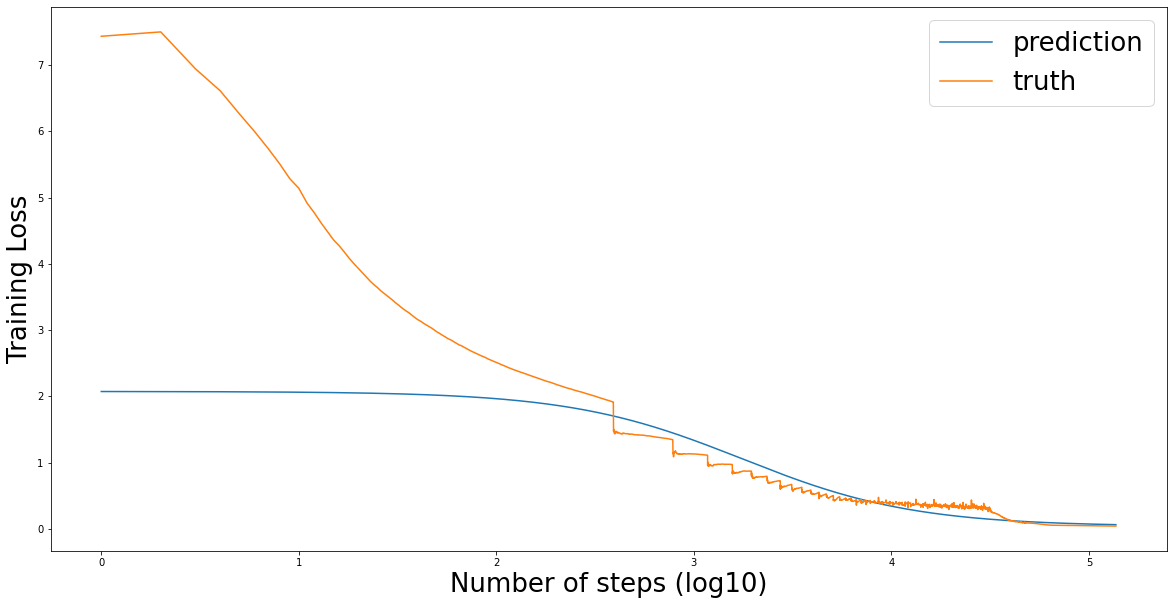

In [58]:
plt.plot(np.log10(range(1,len(results_rn50_v100)+1)),predict_resnet50_v100_loss,label="prediction")
plt.plot(np.log10(range(1,len(results_rn50_v100)+1)),results_rn50_v100,label="truth")
plt.legend(fontsize=26)
plt.ylabel("Training Loss",fontsize=26)
plt.xlabel("Number of steps (log10)",fontsize=26)
plt.show()

In [78]:
results_rn50_k80[82*391]-predict_resnet50_k80_loss[82*391].

array([0.11964654])

# The number of epochs is as expected independent of the GPU that was used for the measured values .

In [89]:
# Predicted number of epochs to achieve 82 % accuracy is : (loss values are coming from HW4_training_rn50_k80_p100_v100.ipynb when accuracy reaches 82%)

print(" For resnet 50 , k 80, 82% : ",round([ n for n,i in enumerate(predict_resnet50_k80_loss) if i<0.2746 ][0]/391)," epochs")
print(" For resnet 50 , k 80, prediction error percentage : ",round(int(100*(results_rn50_k80[82*391]-predict_resnet50_k80_loss[82*391])/results_rn50_k80[82*391]))," %")
print()
print(" For resnet 50 , p 100, 82% : ",round([ n for n,i in enumerate(predict_resnet50_p100_loss) if i<0.2825 ][0]/391)," epochs")
print(" For resnet 50 , p 100, prediction error percentage : ",round(int(100*(results_rn50_p100[82*391]-predict_resnet50_p100_loss[82*391])/results_rn50_p100[82*391]))," %")
print()
print(" For resnet 50 , v 100, 82% : ",round([ n for n,i in enumerate(predict_resnet50_v100_loss) if i<0.2700 ][0]/391)," epochs")
print(" For resnet 50 , v 100, prediction error percentage : ",round(int(100*(results_rn50_v100[82*391]-predict_resnet50_v100_loss[82*391])/results_rn50_v100[82*391]))," %")

 For resnet 50 , k 80, 82% :  30  epochs
 For resnet 50 , k 80, prediction error percentage :  47  %

 For resnet 50 , p 100, 82% :  29  epochs
 For resnet 50 , p 100, prediction error percentage :  46  %

 For resnet 50 , v 100, 82% :  35  epochs
 For resnet 50 , v 100, prediction error percentage :  42  %


# Q3)

In [7]:
theta_0 = 1.02
theta_1 = 2.78
theta_2 = 4.92
theta_3 = 0.00
theta_4 = 0.02

def f(w,p,M):
    return (1/(theta_0 * M/w + theta_1 + theta_2 * w/p + theta_3 * w + theta_4*p)*82*391)

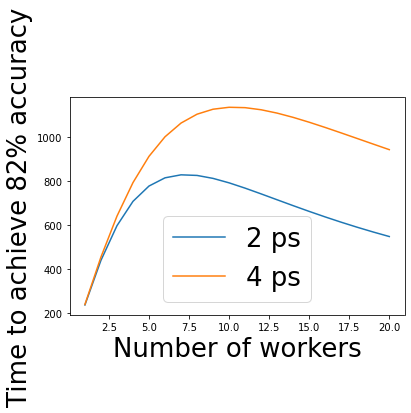

In [8]:
W = range(1,21)
plt.plot(W,[f(w,2,128) for w in W],label = "2 ps")
plt.plot(W,[f(w,4,128) for w in W],label = "4 ps")
plt.legend(fontsize=26)
plt.ylabel("Time to achieve 82% accuracy",fontsize=26)
plt.xlabel("Number of workers",fontsize=26)
plt.show()